## track trajectory segment generation

In [47]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale

from geopy.distance import great_circle
import pyproj

### data exploration

In [120]:
ll_raw = pd.read_csv('../data/acm_track/Highway Loop Left Lane 11-4-2022 (time stamps).csv')
rl_raw = pd.read_csv('../data/acm_track/Highway Loop Right Lane 11-4-2022 (time stamps).csv')

ll_raw.shape, rl_raw.shape

((70817, 25), (82711, 25))

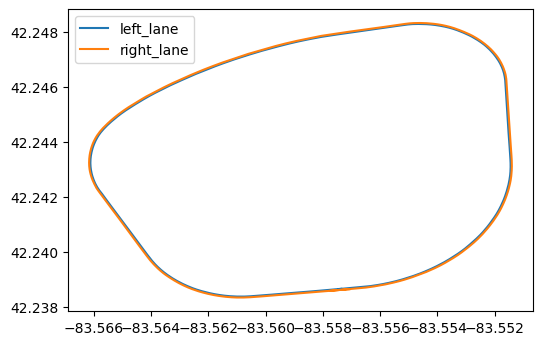

In [133]:
plt.plot(ll_raw['Longitude (deg)'], ll_raw['Latitude (deg)'], label='left_lane')
plt.plot(rl_raw['Longitude (deg)'], rl_raw['Latitude (deg)'], label='right_lane')
plt.legend()

In [3]:
ll_raw.head()

,Time from start of file (s),Latitude (deg),Longitude (deg),Altitude (m),Distance horizontal (m),Velocity forward (m/s),Velocity lateral (m/s),Velocity down (m/s),Speed horizontal (m/s),Heading (deg),...,Angular rate down (deg/s),Angular rate Xv (deg/s),Angular rate Yv (deg/s),Angular rate Zv (deg/s),Acceleration forward (m/s²),Acceleration lateral (m/s²),Acceleration down (m/s²),Acceleration Xv (m/s²),Acceleration Yv (m/s²),Acceleration Zv (m/s²)
0,0.93,42.238643,-83.557448,185.899,0.0,0.01,0.0,0.01,0.01,82.408,...,-0.49,-0.17,-0.87,-0.49,0.021,0.020,-9.435,0.110,-0.005,-9.434
1,0.94,42.238643,-83.557448,185.898,0.0,0.01,0.0,0.01,0.01,82.404,...,-0.39,-0.04,0.18,-0.39,-0.038,-0.054,-9.713,0.054,-0.080,-9.713
2,0.95,42.238643,-83.557448,185.898,0.0,0.01,0.0,0.01,0.01,82.404,...,0.01,-0.03,0.56,0.01,-0.042,-0.014,-10.143,0.054,-0.041,-10.143
3,0.96,42.238643,-83.557448,185.898,0.0,0.01,0.0,0.01,0.01,82.404,...,0.08,0.02,0.71,0.08,0.036,0.043,-9.967,0.132,0.017,-9.966
4,0.97,42.238643,-83.557448,185.898,0.0,0.01,0.0,0.01,0.01,82.410,...,0.57,-0.14,-0.55,0.57,0.027,0.016,-9.502,0.118,-0.009,-9.501


In [86]:
ll_raw[['Velocity forward (m/s)', 'Speed horizontal (m/s)']]

,Velocity forward (m/s),Speed horizontal (m/s)
0,0.01,0.01
1,0.01,0.01
2,0.01,0.01
3,0.01,0.01
4,0.01,0.01
...,...,...
70812,2.49,2.49
70813,2.48,2.48
70814,2.47,2.47
70815,2.46,2.46


In [4]:
ll_raw.columns

Index(['Time from start of file (s)', 'Latitude (deg)', 'Longitude (deg)',
       'Altitude (m)', 'Distance horizontal (m)', 'Velocity forward (m/s)',
       'Velocity lateral (m/s)', 'Velocity down (m/s)',
       'Speed horizontal (m/s)', 'Heading (deg)', 'Pitch (deg)', 'Roll (deg)',
       'Slip angle (deg)', 'Angular rate forward (deg/s)',
       'Angular rate lateral (deg/s)', 'Angular rate down (deg/s)',
       'Angular rate Xv (deg/s)', 'Angular rate Yv (deg/s)',
       'Angular rate Zv (deg/s)', 'Acceleration forward (m/s²)',
       'Acceleration lateral (m/s²)', 'Acceleration down (m/s²)',
       'Acceleration Xv (m/s²)', 'Acceleration Yv (m/s²)',
       'Acceleration Zv (m/s²)'],
      dtype='object')

In [121]:
coln_to_keep  = [
    'Latitude (deg)', 'Longitude (deg)', # GPS
    'Velocity lateral (m/s)', 'Velocity forward (m/s)', # speed
    'Heading (deg)', 'Pitch (deg)', 'Roll (deg)', # IMU measurements
    'Angular rate Xv (deg/s)', 'Angular rate Yv (deg/s)',
    'Acceleration Xv (m/s²)', 'Acceleration Yv (m/s²)',
]

ll = ll_raw[coln_to_keep]
rl = rl_raw[coln_to_keep]

ll.rename(columns={
    'Latitude (deg)': 'y', 'Longitude (deg)': 'x',
    'Velocity lateral (m/s)': 'Vy', 'Velocity forward (m/s)': 'Vx',
    'Heading (deg)': 'theta', 'Pitch (deg)': 'psi', 'Roll (deg)': 'phi',
    'Angular rate Xv (deg/s)': 'omega_Xv', 'Angular rate Yv (deg/s)': 'omega_Yv',
    'Acceleration Xv (m/s²)': 'alpha_Xv', 'Acceleration Yv (m/s²)': 'alpha_Yv'
}, inplace=True
)

rl.rename(columns={
    'Latitude (deg)': 'y', 'Longitude (deg)': 'x',
    'Velocity lateral (m/s)': 'Vy', 'Velocity forward (m/s)': 'Vx',
    'Heading (deg)': 'theta', 'Pitch (deg)': 'psi', 'Roll (deg)': 'phi',
    'Angular rate Xv (deg/s)': 'omega_Xv', 'Angular rate Yv (deg/s)': 'omega_Yv',
    'Acceleration Xv (m/s²)': 'alpha_Xv', 'Acceleration Yv (m/s²)': 'alpha_Yv'
}, inplace=True
)

ll.head()

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv
0,42.238643,-83.557448,0.0,0.01,82.408,0.538,0.155,-0.17,-0.87,0.110,-0.005
1,42.238643,-83.557448,0.0,0.01,82.404,0.540,0.154,-0.04,0.18,0.054,-0.080
2,42.238643,-83.557448,0.0,0.01,82.404,0.546,0.154,-0.03,0.56,0.054,-0.041
3,42.238643,-83.557448,0.0,0.01,82.404,0.553,0.154,0.02,0.71,0.132,0.017
4,42.238643,-83.557448,0.0,0.01,82.410,0.547,0.153,-0.14,-0.55,0.118,-0.009


In [100]:
ll.to_csv('../data/acm_track/ll_clean.csv.gzip', compression='gzip')
rl.to_csv('../data/acm_track/rl_clean.csv.gzip', compression='gzip')

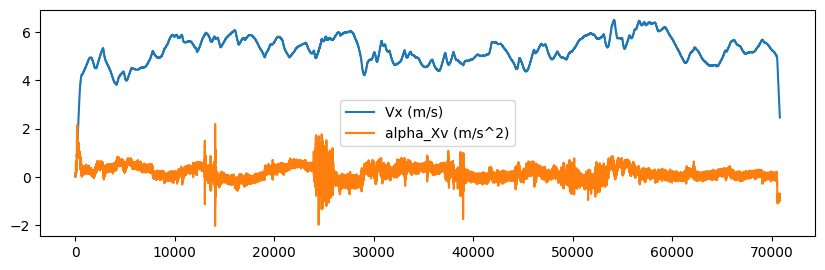

In [12]:
plt.figure(figsize=(10, 3))
ll['Vx'].plot(label='Vx (m/s)')
ll['alpha_Xv'].plot(label='alpha_Xv (m/s^2)')

plt.legend()

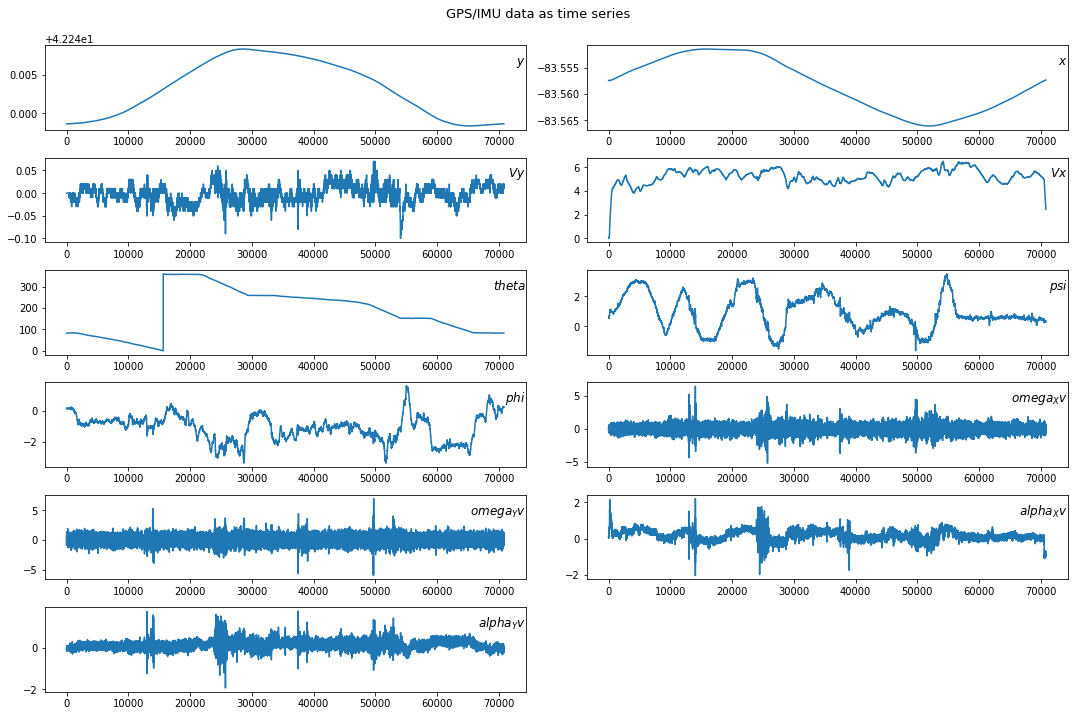

In [27]:
fig, axs = plt.subplots(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("GPS/IMU data as time series", fontsize=13, y=0.99)

for i, coln in enumerate(ll.columns):
    ax = plt.subplot(6, 2, i + 1)
    ll[coln].plot(ax=ax)
    ax.set_title(rf'${coln}$', y=0.7, loc='right')

plt.tight_layout()
plt.show()

In [40]:
ll_scaled = scale(ll)
pca = decomposition.PCA(n_components=2)
ll_pca = pca.fit_transform(ll_scaled)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_matrix = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=ll.columns)
loadings_matrix.sort_values(by='PC1', ascending=False)

,PC1,PC2
alpha_Xv,0.416552,0.408259
psi,0.415674,0.425097
phi,0.414015,-0.111265
x,0.140367,0.265251
Vy,0.023748,-0.197603
omega_Xv,-0.012431,-0.021253
omega_Yv,-0.013885,0.015800
Vx,-0.291432,-0.214695
alpha_Yv,-0.344897,0.147018
y,-0.354666,0.487691


### feature engineering

In [111]:
# check for null values
ll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70817 entries, 0 to 70816
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         70817 non-null  float64
 1   x         70817 non-null  float64
 2   Vy        70817 non-null  float64
 3   Vx        70817 non-null  float64
 4   theta     70817 non-null  float64
 5   psi       70817 non-null  float64
 6   phi       70817 non-null  float64
 7   omega_Xv  70817 non-null  float64
 8   omega_Yv  70817 non-null  float64
 9   alpha_Xv  70817 non-null  float64
 10  alpha_Yv  70817 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


In [112]:
# check for null values
rl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70817 entries, 0 to 70816
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         70817 non-null  float64
 1   x         70817 non-null  float64
 2   Vy        70817 non-null  float64
 3   Vx        70817 non-null  float64
 4   theta     70817 non-null  float64
 5   psi       70817 non-null  float64
 6   phi       70817 non-null  float64
 7   omega_Xv  70817 non-null  float64
 8   omega_Yv  70817 non-null  float64
 9   alpha_Xv  70817 non-null  float64
 10  alpha_Yv  70817 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


creating ll_gpd and rl_gpd

In [75]:
ll_gpd = gpd.GeoDataFrame(ll, geometry=gpd.points_from_xy(ll['x'], ll['y']))
rl_gpd = gpd.GeoDataFrame(rl, geometry=gpd.points_from_xy(rl['x'], rl['y']))

ll_gpd = ll_gpd.set_crs(epsg='4326')
rl_gpd = rl_gpd.set_crs(epsg='4326')

ll_gpd = ll_gpd.to_crs(epsg='3857')
rl_gpd = rl_gpd.to_crs(epsg='3857')

ll_gpd['x'] = ll_gpd.geometry.x
ll_gpd['y'] = ll_gpd.geometry.y
rl_gpd['x'] = rl_gpd.geometry.x
rl_gpd['y'] = rl_gpd.geometry.y

ll_gpd.drop('geometry', inplace=True, axis=1)
rl_gpd.drop('geometry', inplace=True, axis=1)

In [76]:
# epsg='3857'
rl_gpd.head()

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv
0,5.196794e+06,-9.301573e+06,0.0,0.01,82.408,0.538,0.155,-0.17,-0.87,0.110,-0.005
1,5.196794e+06,-9.301573e+06,0.0,0.01,82.404,0.540,0.154,-0.04,0.18,0.054,-0.080
2,5.196794e+06,-9.301573e+06,0.0,0.01,82.404,0.546,0.154,-0.03,0.56,0.054,-0.041
3,5.196794e+06,-9.301573e+06,0.0,0.01,82.404,0.553,0.154,0.02,0.71,0.132,0.017
4,5.196794e+06,-9.301573e+06,0.0,0.01,82.410,0.547,0.153,-0.14,-0.55,0.118,-0.009


In [89]:
def next_coord_conversion(coord1, coord2, coord_prev=[0, 0]):

    x0 = coord_prev[0]
    y0 = coord_prev[1]
    lat1 = coord1[0] # x
    lon1 = coord1[1] # y
    lat2 = coord2[0]
    lon2 = coord2[1]

    geodesic = pyproj.Geod(ellps='WGS84')
    bearing, inv_bearing, distance = geodesic.inv(lon1, lat1, lon2, lat2)

    coord_next = [
        x0 + distance * math.cos(bearing * math.pi / 180), 
        y0 + distance * math.sin(bearing * math.pi / 180)
    ]

    return coord_next

In [122]:
# runtime ~= 30s

ll_coord_next_lst = []
rl_coord_next_lst = []

for index, row in ll.iterrows():
    
    coord1 = [row['y'], row['x']]
    
    if index == 0:
        coord2 = [ll.iloc[index+1]['y'], ll.iloc[index+1]['x']]
        coord_next = next_coord_conversion(coord1, coord2)
    elif index == ll.shape[0]-1:
        pass
    else:
        coord2 = [ll.iloc[index+1]['y'], ll.iloc[index+1]['x']]
        coord_prev = ll_coord_next_lst[-1]
        coord_next = next_coord_conversion(coord1, coord2, coord_prev)
    
    ll_coord_next_lst.append(coord_next)

for index, row in rl.iterrows():
    
    coord1 = [row['y'], row['x']]
    
    if index == 0:
        coord2 = [rl.iloc[index+1]['y'], rl.iloc[index+1]['x']]
        coord_next = next_coord_conversion(coord1, coord2)
    elif index == rl.shape[0]-1:
        pass
    else:
        coord2 = [rl.iloc[index+1]['y'], rl.iloc[index+1]['x']]
        coord_prev = rl_coord_next_lst[-1]
        coord_next = next_coord_conversion(coord1, coord2, coord_prev)
    
    rl_coord_next_lst.append(coord_next)

In [123]:
ll_coord_next_lst = np.asarray(ll_coord_next_lst)
rl_coord_next_lst = np.asarray(rl_coord_next_lst)

print(min(ll_coord_next_lst[:, 0]), min(ll_coord_next_lst[:, 1]))
print(min(rl_coord_next_lst[:, 0]), min(rl_coord_next_lst[:, 1]))

ll_coord_next_lst[:, 0] = ll_coord_next_lst[:, 0] - min(ll_coord_next_lst[:, 0])
ll_coord_next_lst[:, 1] = ll_coord_next_lst[:, 1] - min(ll_coord_next_lst[:, 1])

rl_coord_next_lst[:, 0] = rl_coord_next_lst[:, 0] - min(rl_coord_next_lst[:, 0])
rl_coord_next_lst[:, 1] = rl_coord_next_lst[:, 1] - min(rl_coord_next_lst[:, 1])

-30.446450896810518 -715.0895788850106
-27.58952733857783 -695.8411560569565


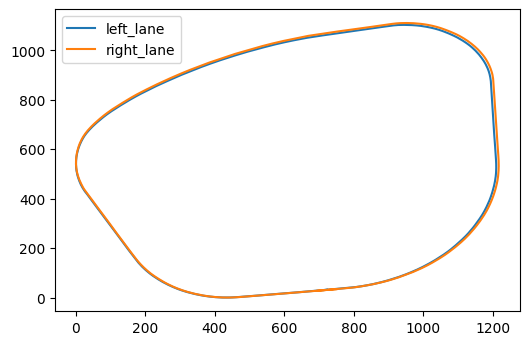

In [124]:
plt.plot(ll_coord_next_lst[:, 1], ll_coord_next_lst[:, 0], label='left_lane')
plt.plot(rl_coord_next_lst[:, 1], rl_coord_next_lst[:, 0], label='right_lane')
plt.legend()

In [125]:
ll['y'] = ll_coord_next_lst[:, 0]
ll['x'] = ll_coord_next_lst[:, 1]

rl['y'] = rl_coord_next_lst[:, 0]
rl['x'] = rl_coord_next_lst[:, 1]

In [126]:
x_max = np.max(rl['x'])
y_max = np.max(rl['y'])
x_min = np.min(rl['x'])
y_min = np.min(rl['y'])

# 01/26: convert angular rates to rad/s
ll['omega_Xv'] = ll['omega_Xv'] * np.pi/180
ll['omega_Yv'] = ll['omega_Yv'] * np.pi/180

rl['omega_Xv'] = rl['omega_Xv'] * np.pi/180
rl['omega_Yv'] = rl['omega_Yv'] * np.pi/180

In [6]:
print(x_max, y_max)
print(x_min, y_min)

# normalize GPS trajectory and IMU columns
for coln in ll.columns:
    ll[f'{coln}_norm'] = MinMaxScaler().fit_transform(np.array(ll[f'{coln}']).reshape(-1,1))
    rl[f'{coln}_norm'] = MinMaxScaler().fit_transform(np.array(rl[f'{coln}']).reshape(-1,1))
    
    if coln != 'x' and coln != 'y':
        ll.drop([f'{coln}'], inplace=True, axis=1)
        rl.drop([f'{coln}'], inplace=True, axis=1)

-83.55144472 42.24829894
-83.56611364 42.23836889


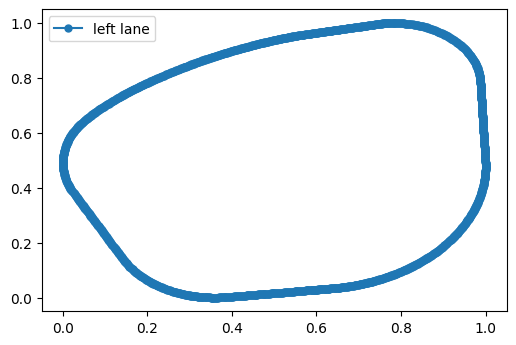

In [90]:
# test track loop
plt.figure(dpi=100)

ll_5hz = ll.iloc[::round(250 / 5)]
plt.plot(ll_5hz.x_norm, ll_5hz.y_norm, '-o', label='left lane', ms=5)
# plt.plot(ll.x_norm, ll.y_norm, '--', label='left lane')
plt.legend()
plt.show()

In [73]:
# distance [m] between trajectory points

great_circle((ll_5hz.iloc[0, 0], ll_5hz.iloc[0, 1]), (ll_5hz.iloc[1, 0], ll_5hz.iloc[1, 1])).meters

0.004263719397356457

In [4]:
# lane encoding
# 0: left lane
# 1: right lane

ll['lane'] = 0
rl['lane'] = 1
ll.head(5)

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,lane
0,42.238643,-83.557448,0.0,0.01,82.408,0.538,0.155,-0.17,-0.87,0.110,-0.005,0
1,42.238643,-83.557448,0.0,0.01,82.404,0.540,0.154,-0.04,0.18,0.054,-0.080,0
2,42.238643,-83.557448,0.0,0.01,82.404,0.546,0.154,-0.03,0.56,0.054,-0.041,0
3,42.238643,-83.557448,0.0,0.01,82.404,0.553,0.154,0.02,0.71,0.132,0.017,0
4,42.238643,-83.557448,0.0,0.01,82.410,0.547,0.153,-0.14,-0.55,0.118,-0.009,0


In [124]:
ll.describe().round(3)

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,theta_norm,Vx_norm,Vy_norm,lane
count,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.000,70817.0
mean,42.243,-83.558,-0.002,5.232,183.517,0.935,-1.102,0.007,0.015,0.164,0.141,0.492,0.536,0.510,0.805,0.574,0.0
std,0.004,0.005,0.019,0.620,104.608,1.141,0.837,0.556,0.649,0.259,0.181,0.360,0.344,0.291,0.096,0.110,0.0
min,42.238,-83.566,-0.100,0.010,0.001,-1.657,-3.367,-5.170,-5.980,-2.033,-1.926,0.000,0.000,0.000,0.000,0.000,0.0
25%,42.239,-83.563,-0.010,4.870,83.286,0.335,-1.719,-0.320,-0.390,-0.005,0.024,0.105,0.207,0.231,0.749,0.529,0.0
50%,42.243,-83.558,0.000,5.230,190.418,0.690,-0.988,0.010,0.010,0.138,0.132,0.508,0.552,0.529,0.804,0.588,0.0
75%,42.247,-83.553,0.010,5.680,258.478,1.768,-0.566,0.330,0.410,0.346,0.251,0.852,0.879,0.718,0.874,0.647,0.0
max,42.248,-83.551,0.070,6.500,359.996,3.521,1.574,6.460,6.970,2.193,1.762,1.000,1.000,1.000,1.000,1.000,0.0


### Ground Truth Segment Generation
- generate 500 ground truth segments from the surveyed test track (center lane)
- each ground truth segments is around 200m in length, with 100*standard normal distribution
- coordinates are normalized to 0-1
- no noise and sub-sampling are performed at this step
- training and validation set: left lane
- testing: right lane

In [111]:
def seg_generation(traj_truth_df, seg_size, seg_size_sig, num_samples=500, seed=0):
    
    # ensure reproducibility
    np.random.seed(seed)
    seg_gt = []

    for x in np.random.randint(traj_truth_df.shape[0]-seg_size, size=num_samples):
        seg_size += round(seg_size_sig * randn())
        # seg_sample.append(traj_truth_df[x:x+seg_size, :])
        seg_gt.append(traj_truth_df.iloc[x:x+seg_size])

    return seg_gt

In [127]:
tot_dist = ll_raw.iloc[-1]['Distance horizontal (m)']
seg_dist = 200 # [m]
seg_size = round(seg_dist / (tot_dist / ll.shape[0])) # convert to the length of sample
seg_size_sig = 0 # 100 # length variance

# save all columns
ll_seg_gt = seg_generation(ll, seg_size, seg_size_sig)
rl_seg_gt = seg_generation(rl, seg_size, seg_size_sig)
# ll_seg_gt = seg_generation(ll, seg_size, seg_size_sig)
# rl_seg_gt = seg_generation(rl, seg_size, seg_size_sig)

# save only GPS coordinate columns
gps_colns = ['y', 'x']# , 'y_norm', 'x_norm']
ll_seg_gps_gt = seg_generation(ll[gps_colns], seg_size, seg_size_sig)
rl_seg_gps_gt = seg_generation(ll[gps_colns], seg_size, seg_size_sig)

In [128]:
# save to files
# runtime ~= 1.5min

with gzip.open('../data/segment_groud_truth_v2/ll_seg_gt_500_v2.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_gt, f)
with gzip.open('../data/segment_groud_truth_v2/rl_seg_gt_500_v2.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_gt, f)

with gzip.open('../data/segment_groud_truth_v2/ll_seg_gps_gt_500_v2.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_gps_gt, f)
with gzip.open('../data/segment_groud_truth_v2/rl_seg_gps_gt_500_v2.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_gps_gt, f)

In [43]:
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gt = pickle.load(f)

print(len(ll_seg_gt))
print(ll_seg_gt[0].shape[0])
ll_seg_gt[0].head()

500
3822


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,lane
43567,42.246179,-83.563086,0.03,5.06,237.273,0.538,-1.124,0.26,-0.65,0.114,0.264,0.786530,0.206384,0
43568,42.246179,-83.563087,0.04,5.06,237.270,0.531,-1.120,0.38,-0.65,-0.068,0.324,0.786505,0.206349,0
43569,42.246179,-83.563087,0.04,5.05,237.261,0.541,-1.115,0.55,1.01,-0.057,0.244,0.786480,0.206314,0
43570,42.246178,-83.563088,0.04,5.05,237.262,0.546,-1.110,0.47,0.43,-0.082,0.268,0.786456,0.206278,0
43571,42.246178,-83.563088,0.04,5.05,237.261,0.539,-1.106,0.45,-0.63,0.063,0.069,0.786431,0.206244,0


In [ ]:
# visualize the generated segments on the test track
plt.figure(dpi=100)
plt.plot(ll.x_norm, ll.y_norm)
for i in np.arange(100):
    plt.plot(ll_seg_gt[i].x_norm, ll_seg_gt[i].y_norm, linewidth=7, label='sample segment 1')

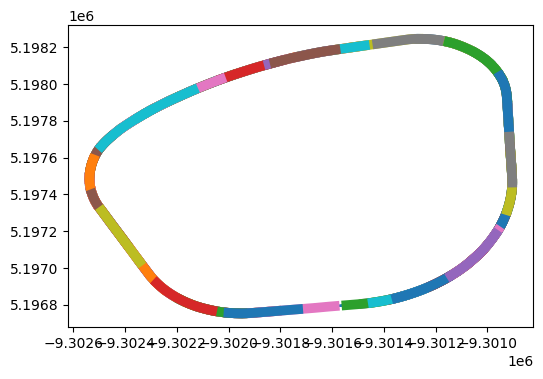

In [41]:
# visualize the generated segments on the test track
plt.figure(dpi=100)
plt.plot(ll_gpd.x, ll_gpd.y)
for i in np.arange(100):
    plt.plot(ll_seg_gt[i].x, ll_seg_gt[i].y, linewidth=7, label='sample segment 1')

### Noisey Sampled Segment Generation [v1]
- generate noisey sampled GPS trajectory segments based on the corresponding ground truth segments from prev. step
- using normalized coordinates
- GPS noises are sampled from a standard normal distribution with a percentage multiplier
    - 0.5% error added to both longitudinal and latitudinal direction, using normalized coordinates
- sampled from 250Hz to 5Hz

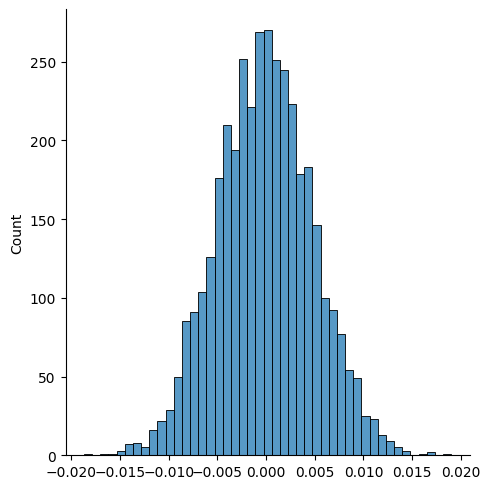

In [139]:
# noise distribution
sns.displot(0.005 * randn(*ll_seg_gt[0]['x'].shape))

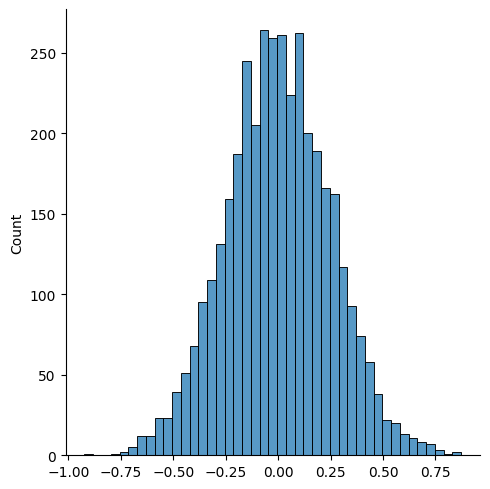

In [46]:
# noise distribution
sns.displot(0.25*randn(*ll_seg_gt[0]['x'].shape))

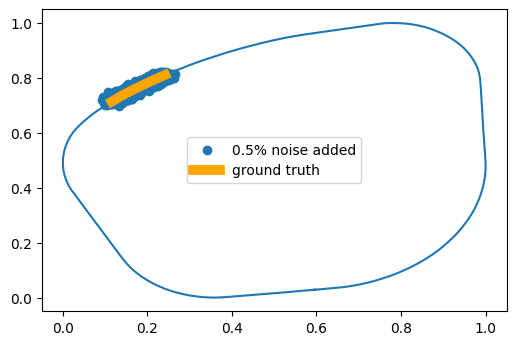

In [132]:
plt.figure(dpi=100)
plt.plot(ll.x_norm, ll.y_norm)
plt.scatter(ll_seg_gps_gt[1].x_norm + 0.01 * randn(*ll_seg_gps_gt[1]['x'].shape), ll_seg_gps_gt[1].y_norm + 0.005 * randn(*ll_seg_gps_gt[1]['y'].shape), label='0.5% noise added')
plt.plot(ll_seg_gps_gt[1].x_norm, ll_seg_gps_gt[1].y_norm, linewidth=7, label='ground truth', color='orange')
plt.legend()

#### add_gps_noise_downsample()

In [38]:
def add_gps_noise_downsample(seg_samples, sampling_rate, noise_perc, seed=0):
    """
    seg_samples: list of df, ll_seg_samples
    sampling_rate: unit [hz]
    noise_perc: 0-1, fraction
    """

    np.random.seed(seed)
    # known: the sample rate of the RTK-GPS unit is 250hz
    rtk_sampling_rate = 250
    sampling_spacing = round(rtk_sampling_rate / sampling_rate)
    seg_samples_gps = []

    for seg_sample in seg_samples:
        seg_sample = seg_sample.iloc[::sampling_spacing]
        seg_sample['y_noise'] = seg_sample['y'] + noise_perc * randn(*seg_sample['y'].shape)
        seg_sample['x_noise'] = seg_sample['x'] + noise_perc * randn(*seg_sample['x'].shape)
        seg_samples_gps.append(seg_sample)

    return seg_samples_gps

In [ ]:
# downsample from 250hz to 1hz, adding 1% spatial noise

ll_seg_gps_noise = add_gps_noise_downsample(ll_seg_gps_gt, 5, 0.005)
rl_seg_gps_noise = add_gps_noise_downsample(rl_seg_gps_gt, 5, 0.005)

ll_seg_noise = add_gps_noise_downsample(ll_seg_gt, 5, 0.005)
rl_seg_noise = add_gps_noise_downsample(rl_seg_gt, 5, 0.005)

KeyError: 'y_norm'

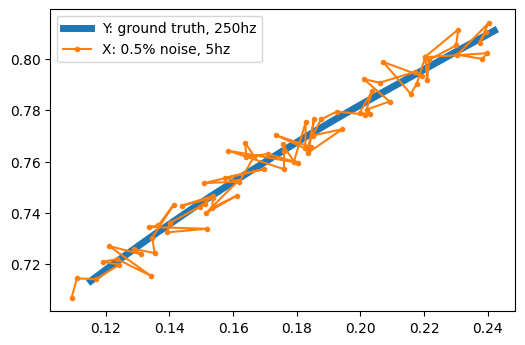

In [14]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.figure(dpi=100)
plt.plot(ll_seg_gt[1].x_norm, ll_seg_gt[1].y_norm, linewidth=5, label='Y: ground truth, 250hz')
plt.plot(ll_seg_gps_noise[1].x_norm_noise, ll_seg_gps_noise[1].y_norm_noise, '-o', label='X: 0.5% noise, 5hz', ms=3)

plt.legend()

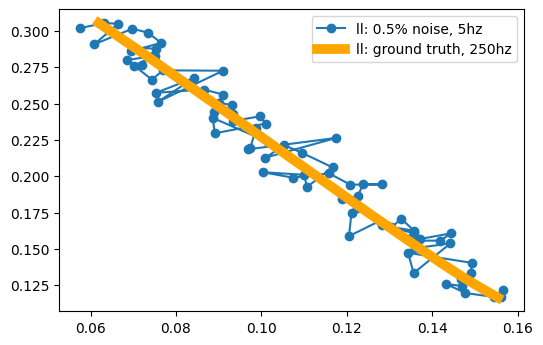

In [50]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.figure(dpi=100)
plt.plot(ll_seg_gps_noise[200].x_norm_noise, ll_seg_gps_noise[200].y_norm_noise, '-o', label='ll: 0.5% noise, 5hz')
plt.plot(ll_seg_gt[200].x_norm, ll_seg_gt[200].y_norm, linewidth=7, label='ll: ground truth, 250hz', color='orange')

plt.legend()

In [15]:
def add_gps_noise_downsample_gpd(seg_samples, sampling_rate, noise_perc, seed=0):
    """
    seg_samples: list of df, ll_seg_samples
    sampling_rate: unit [hz]
    noise_perc: 0-1, fraction
    """

    np.random.seed(seed)
    # known: the sample rate of the RTK-GPS unit is 250hz
    rtk_sampling_rate = 250
    sampling_spacing = round(rtk_sampling_rate / sampling_rate)
    seg_samples_gps = []

    for seg_sample in seg_samples:
        seg_sample = seg_sample.iloc[::sampling_spacing]
        seg_sample['y_noise'] = seg_sample['y'] + noise_perc * randn(*seg_sample['y'].shape)
        seg_sample['x_noise'] = seg_sample['x'] + noise_perc * randn(*seg_sample['x'].shape)
        seg_samples_gps.append(seg_sample)

    return seg_samples_gps

In [16]:
# downsample from 250hz to 1hz, adding 1% spatial noise

ll_seg_gps_noise = add_gps_noise_downsample_gpd(ll_seg_gps_gt, 10, 0.0001)
rl_seg_gps_noise = add_gps_noise_downsample_gpd(rl_seg_gps_gt, 10, 0.0001)

ll_seg_noise = add_gps_noise_downsample_gpd(ll_seg_gt, 10, 0.0001)
rl_seg_noise = add_gps_noise_downsample_gpd(rl_seg_gt, 10, 0.0001)

In [14]:
ll_seg_gt[0]

,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,lane
43567,42.246179,-83.563086,0.03,5.06,237.273,0.538,-1.124,0.26,-0.65,0.114,0.264,0
43568,42.246179,-83.563087,0.04,5.06,237.270,0.531,-1.120,0.38,-0.65,-0.068,0.324,0
43569,42.246179,-83.563087,0.04,5.05,237.261,0.541,-1.115,0.55,1.01,-0.057,0.244,0
43570,42.246178,-83.563088,0.04,5.05,237.262,0.546,-1.110,0.47,0.43,-0.082,0.268,0
43571,42.246178,-83.563088,0.04,5.05,237.261,0.539,-1.106,0.45,-0.63,0.063,0.069,0
...,...,...,...,...,...,...,...,...,...,...,...,...
47384,42.245146,-83.564889,0.00,5.34,226.473,0.860,-1.034,-0.30,-0.19,-0.053,0.314,0
47385,42.245146,-83.564889,0.00,5.34,226.471,0.862,-1.039,-0.44,0.30,0.067,0.285,0
47386,42.245145,-83.564890,0.00,5.34,226.462,0.863,-1.037,0.24,0.06,-0.163,0.166,0
47387,42.245145,-83.564890,0.01,5.34,226.455,0.863,-1.042,-0.46,0.06,-0.058,0.411,0


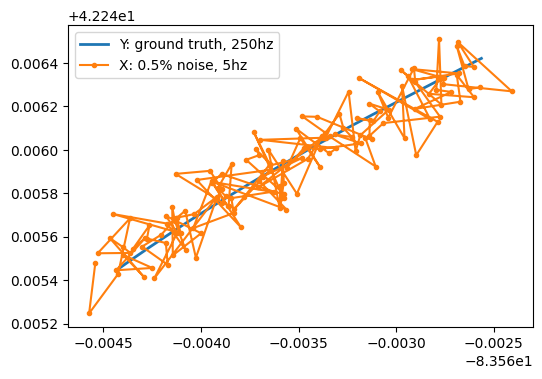

In [17]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.figure(dpi=100)
plt.plot(ll_seg_gt[1].x, ll_seg_gt[1].y, linewidth=2, label='Y: ground truth, 250hz')
plt.plot(ll_seg_gps_noise[1].x_noise, ll_seg_gps_noise[1].y_noise, '-o', label='X: 0.5% noise, 5hz', ms=3)

plt.legend()

<Figure size 600x400 with 0 Axes>

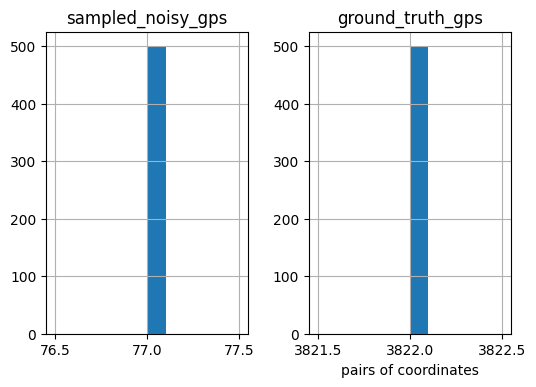

In [51]:
x_count = []
y_count = []

for x_seg in ll_seg_gps_noise:
    x_count.append(len(x_seg))
for y_seg in ll_seg_gt:
    y_count.append(len(y_seg))

graph_df = pd.DataFrame() 
graph_df['sampled_noisy_gps'] = x_count
graph_df['ground_truth_gps'] = y_count

plt.figure(dpi=100)
graph_df.hist(bins = 10)
plt.xlabel('pairs of coordinates')
plt.show()

In [84]:
# save as pickle objects

with gzip.open('../data/segment_with_noise_v3/ll_seg_500_noise_v3.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_noise, f)
with gzip.open('../data/segment_with_noise_v3/rl_seg_500_noise_v3.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_noise, f)

with gzip.open('../data/segment_with_noise_v3/ll_seg_gps_500_noise_v3.pkl.gzip', 'wb') as f:
    pickle.dump(ll_seg_gps_noise, f)
with gzip.open('../data/segment_with_noise_v3/rl_seg_gps_500_noise_v3.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_gps_noise, f)

### Noisey Sampled Segment Generation [v2]

To closer resemble the DGPS unit:
- 10hz frequency
- spatial resolution to < 1m maximum == 0.02% noise from standard normal

In [36]:
noise = np.random.normal(0, 1, size=(1000, 2)) * 0.000002
noise[:,0] = noise[:,0] # * (x_max - x_min) + x_min
noise[:,1] = noise[:,1] # * (y_max - y_min) + y_min
noise = list(zip(noise[:,0], noise[:,1]))

zeros = np.zeros((1000, 2))
zeros[:,0] = zeros[:,0] # * (x_max - x_min) + x_min
zeros[:,1] = zeros[:,1] # * (y_max - y_min) + y_min
zeros = list(zip(zeros[:,0], zeros[:,1]))

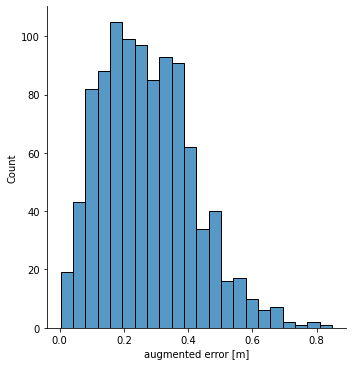

In [37]:
# augmented noise distribution in meters

distances = [great_circle(noise[i], zeros[i]).miles * 1609.34 for i in np.arange(1000)]
sns.displot(distances)
plt.xlabel('augmented error [m]')
plt.show()

In [39]:
# downsample from 250hz to 10hz, adding 0.02% spatial noise

ll_seg_noise = add_gps_noise_downsample(ll_seg_gt, 10, 0.000002)
rl_seg_noise = add_gps_noise_downsample(rl_seg_gt, 10, 0.000002)

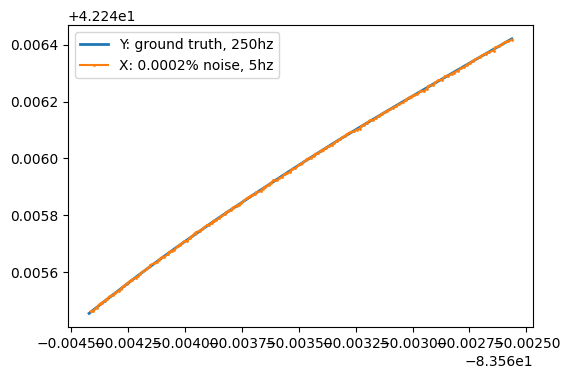

In [42]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.figure(dpi=100)
plt.plot(ll_seg_gt[1].x, ll_seg_gt[1].y, linewidth=2, label='Y: ground truth, 250hz')
plt.plot(ll_seg_noise[1].x_noise, ll_seg_noise[1].y_noise, '-o', label='X: 0.0002% noise, 5hz', ms=1)

plt.legend()

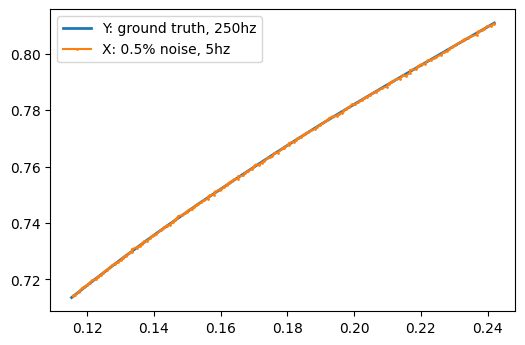

In [19]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.figure(dpi=100)
plt.plot(ll_seg_gt[1].x_norm, ll_seg_gt[1].y_norm, linewidth=2, label='Y: ground truth, 250hz')
plt.plot(ll_seg_noise[1].x_norm_noise, ll_seg_noise[1].y_norm_noise, '-o', label='X: 0.5% noise, 5hz', ms=1)

plt.legend()

In [44]:
# save as pickle objects

with gzip.open('../data/segment_with_noise_v2/ll_seg_500_noise_v2.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_noise, f)
with gzip.open('../data/segment_with_noise_v2/rl_seg_500_noise_v2.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_noise, f)

### Noisey Sampled Segment Generation [v3]

Using reprojected GPS coordinates onto a x, y > 0 coordinate system
- 10hz frequency
- spatial resolution to < 1m maximum == 0.25% noise from standard normal
- using the standard normal directly

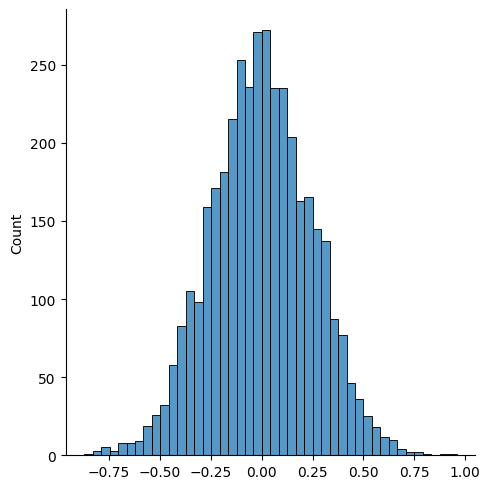

In [109]:
# noise distribution
sns.displot(0.25 * randn(*ll_seg_gt[0]['x'].shape))

In [129]:
# downsample from 250hz to 10hz, adding 25% spatial noise

ll_seg_noise = add_gps_noise_downsample(ll_seg_gt, 10, 0.25)
rl_seg_noise = add_gps_noise_downsample(rl_seg_gt, 10, 0.25)

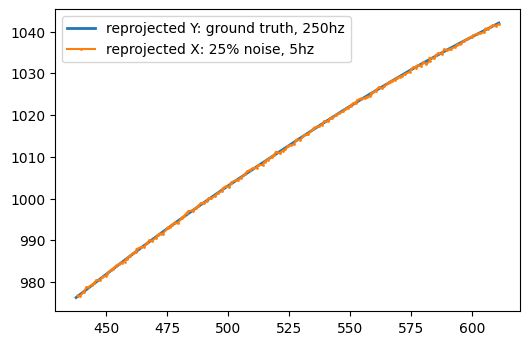

In [130]:
# plt.plot(ll.x_norm, ll.y_norm)
plt.figure(dpi=100)
sample = 1
plt.plot(rl_seg_gt[sample].x, rl_seg_gt[sample].y, linewidth=2, label='reprojected Y: ground truth, 250hz')
plt.plot(rl_seg_noise[sample].x_noise, rl_seg_noise[sample].y_noise, '-o', label='reprojected X: 25% noise, 5hz', ms=1)

plt.legend()

In [131]:
# save as pickle objects

with gzip.open('../data/segment_with_noise_v3/ll_seg_500_noise_v3.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_noise, f)
with gzip.open('../data/segment_with_noise_v3/rl_seg_500_noise_v3.pkl.gzip', 'wb') as f:
    pickle.dump(rl_seg_noise, f)